In [1]:
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib import pyplot
from skimage import color
from skimage import io
import random

To begin, we're going to perform an edge detection task with good old fashioned convolution. In the following code, we'll generate four versions of the same rotated image, convolve the kernel each image to produce four feature maps, and assessing how the kernel response changes with rotation.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  This is separate from the ipykernel package so we can avoid doing imports until


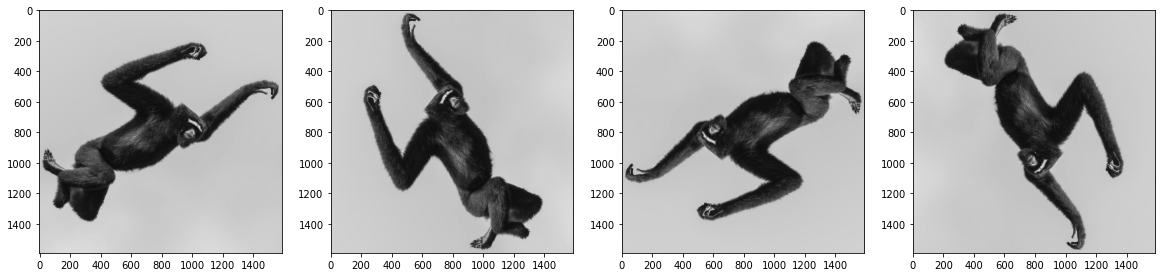

In [4]:
# Feel free to use any image you like.
img = io.imread("gibbon.png")
img_gray = color.rgb2gray(img)

rotated_imgs = [np.rot90(img_gray, i) for i in range(4)]
f,ax = plt.subplots(1,4, figsize=(20,20))

for i,image in enumerate(rotated_imgs):
  ax[i].imshow(image, cmap='gray')

plt.show()

Now that we have our images ready, let's define an edge detection kernel. This will be a boutique, hand-made kernel...no learning necessary.

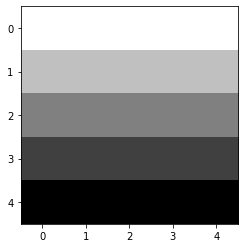

In [5]:
edge_kernel = np.array([
  [1, 1, 1, 1, 1], 
  [0.5, 0.5, 0.5, 0.5, 0.5], 
  [0, 0, 0, 0, 0],
  [-0.5, -0.5, -0.5, -0.5, -0.5], 
  [-1, -1, -1, -1, -1],
])

plt.imshow(edge_kernel, cmap='gray')

Now, we'll define a simple convolution function. This is a standard "sliding-window" operation, wherein the kernel is iterated over the rows and columns of the image, and the corresponding response is recorded in a feature map. We will then be able to compare the feature maps generated by the same kernel and image, but at different rotations to the input.

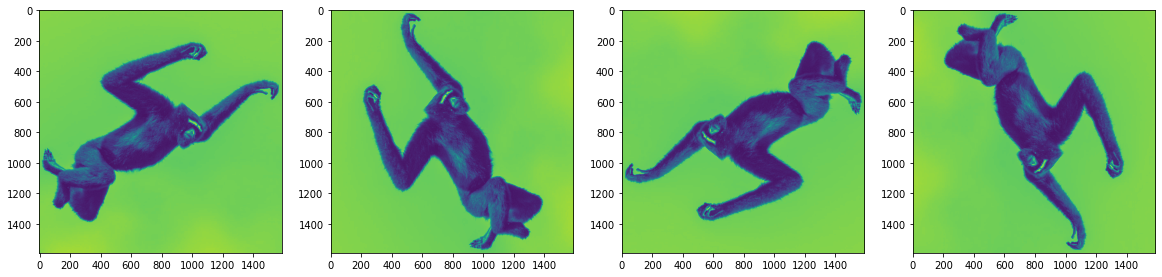

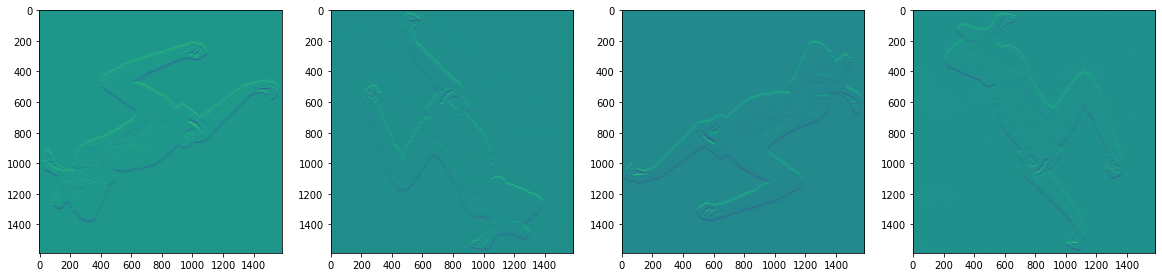

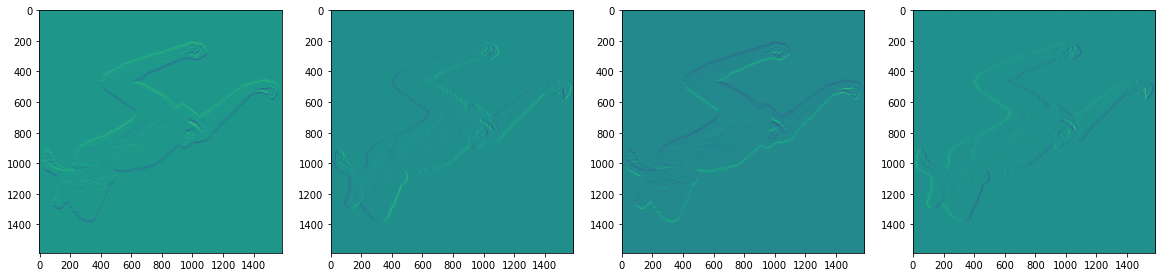

In [7]:
def standard_convolution(image, kernel):
  feature_map = np.zeros((image.shape[0] - kernel.shape[0] + 1,
                        image.shape[1] - kernel.shape[1] + 1))

  for r in range(image.shape[0] - kernel.shape[0]):
    for c in range(image.shape[1] - kernel.shape[1]):
      img_patch = image[r:r+kernel.shape[0], c:c+kernel.shape[1]]
      feature_map[r,c] = np.dot(img_patch.flatten(), kernel.flatten())

  return feature_map

# Perform convolution on each of the rotated input images.
feature_maps = [standard_convolution(image, edge_kernel) for image in rotated_imgs]
aligned_feature_maps = [feature_maps[0]]

for i in range(1, len(feature_maps)):
  aligned_feature_maps.append(np.rot90(feature_maps[i],4-i))

for img_row in [rotated_imgs, feature_maps, aligned_feature_maps]:
  f,ax = plt.subplots(1,4, figsize=(20,20))

  for i,image in enumerate(img_row):
    ax[i].imshow(image)

  plt.show()

The rows above are as follows: 

A) Original rotated images 

B) Corresponding feature maps 

C) Rotationally-aligned feature maps, for ease of viewing and comparison. 

**Question: Compare the feature maps. How does the filter responds to rotation?**

The magnitude of the edges changes based on rotation.  The filter is detecting which is the top and the bottom of the image, with the darker being the bottom and lighter being the top as per the above kernel.  Thus, a rotated image will have different edges near the top and the filter will result in different results.

Ideally, we would like a good edge detection filter to recognize edges without being sensitive to angle. How might we implement such an edge-detector?

Kernels derived from the family of circular harmonics are suited for just that task.

Below, we will implement a method for visualizing continuous harmonic filters, paramaterized by a radial profile function, rotation order, and beta offset term. 

In [23]:
def visualize_polar_filter(radial_profile, order, offset):
  rlist=np.arange(0,1.01,0.01)
  thetalist = np.arange(0, 2*np.pi, np.pi/400)
  rmesh, thetamesh = np.meshgrid(rlist, thetalist)
  
  # TODO: What functions 'f' should be in the list below?
  # HINT: Think Euler's identity
  for f in [np.sin,np.cos]:
    full_function = f(order*thetamesh - offset)*radial_profile(rmesh)
    
    fig,ax = plt.subplots(dpi=120,subplot_kw=dict(projection='polar'))
    ax.contourf(thetamesh,rmesh,full_function,100)
    plt.show()

def visualize_radial_profile(f):
  X = np.arange(0,1,0.01) 
  y = [f(x) for x in X]
  plt.plot(X,y)

def R(r):
  return np.e**(r**2 + r)

**Activity: Generate various harmonic filters with different radial profiles, rotation orders, and beta offset values. How do each of these elements affect the resulting harmonic filter?**

In the filters along a single angle the magnitude is represented by the radial profile.  BY changing the angle the amount real or imaginary is changed with the sine portion representing the imaginary and the cosine portion representing the real portion.  This is along the lines of euler's formula.  Thus, by chaniging the radial profile, the value of the filter along the radius is changed.  The beta offset changes where the scaling for the filter is one (i.e. it shifts where the term inside the cosine is 0).  The rotation order changes how often the filter repeats for a full 360 degrees.

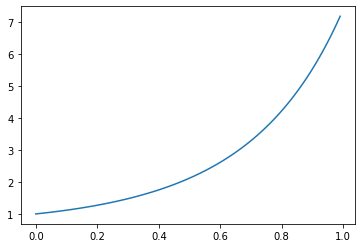

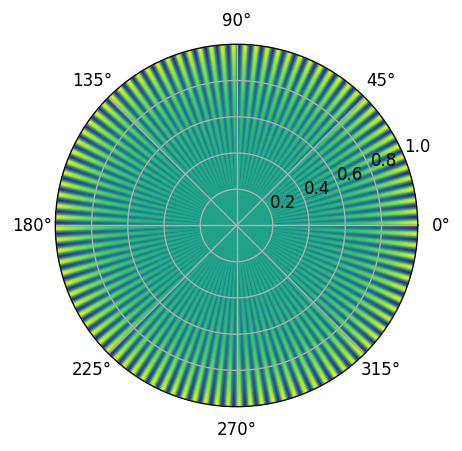

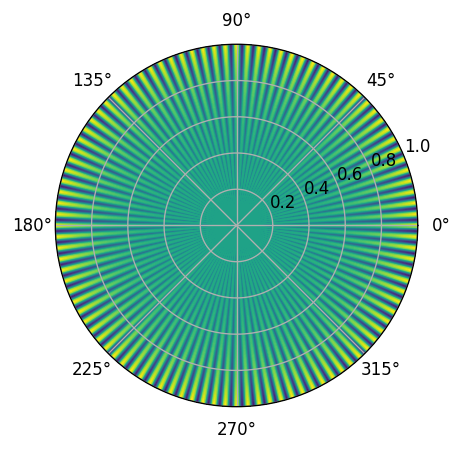

In [28]:
visualize_radial_profile(R)
visualize_polar_filter(R, 100, 0)

So now we can define a continuous circular harmonic filter, but how do we make such a filter compatible with a standard CNN architecture?

We need to discretize the harmonic filter. This process is illustrated well in a figure from a previous version of the paper:


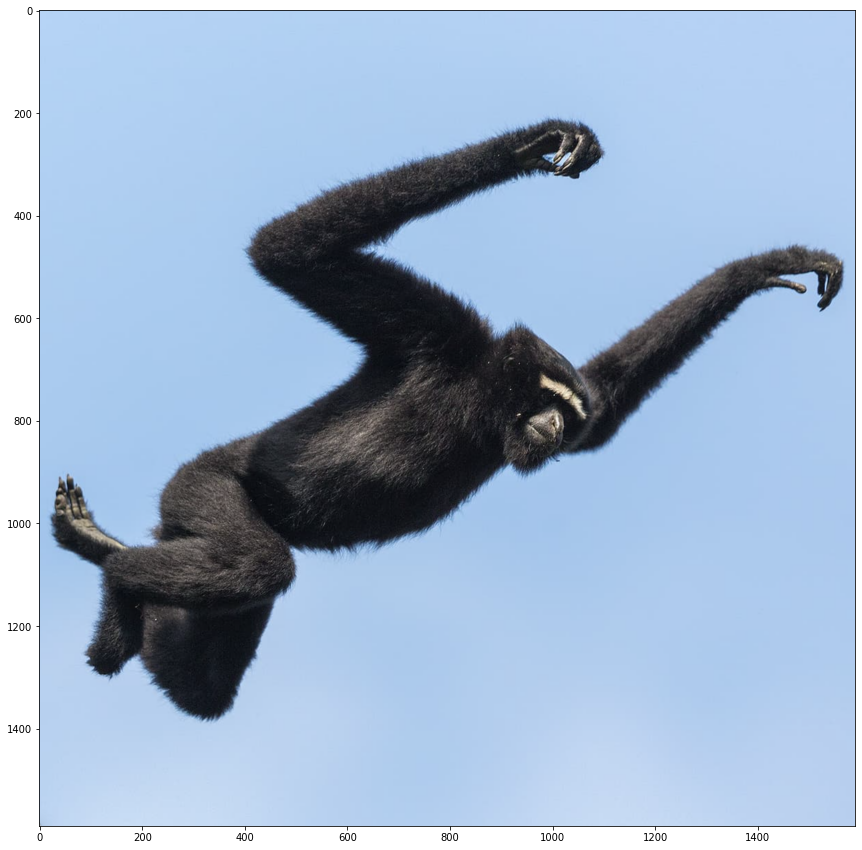

In [13]:
disc_figure = io.imread("discretization.png")
plt.figure(figsize = (15,15))
plt.imshow(img)

The process described in this figure is coded below: We take some radial profile function (edge_rp) and some order to generate samples of various angles and radii from the continuous circular harmonic filter.

In [49]:
def edge_rp(r):
  return np.e**(r**2)

def generate_polar_filters(n_rings, n_angles, radial_profile, order):
  polar_filters = [np.zeros((n_angles, n_rings)) for i in range(2)]

  angles = np.arange(0, 2*np.pi, 2*np.pi/n_angles)
  rings = np.arange(0+1/n_rings, 1+1/n_rings, 1/n_rings)

  for i,theta in enumerate(angles):
    for j,r in enumerate(rings):
      for k,f in enumerate([np.cos, np.sin]):
        polar_filters[k][i,j] = radial_profile(r) * f(order * theta)

  return tuple(polar_filters)

polar_filter = generate_polar_filters(5, 12, edge_rp, -1)  

The resulting complex-valued filter may then be discretized according to the W function in the figure above. This is done with the generate_kernel function below.

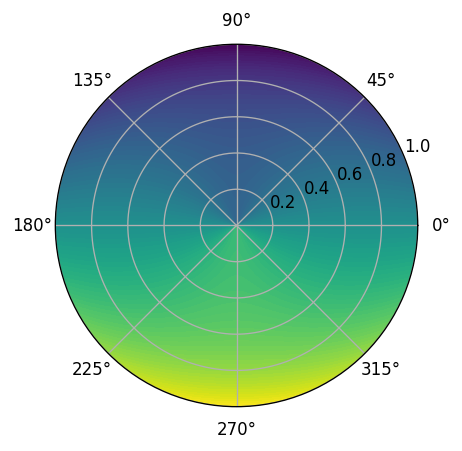

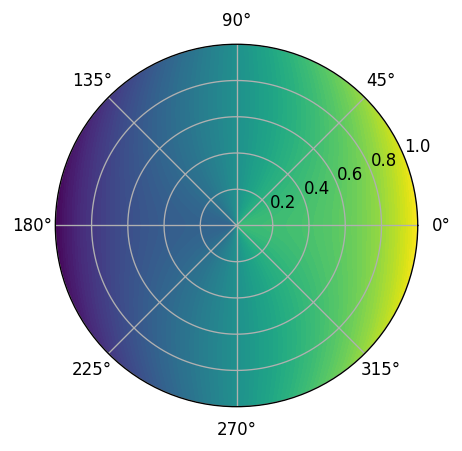

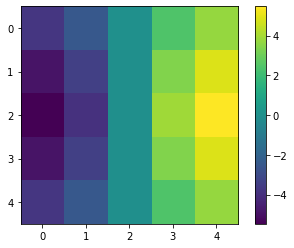

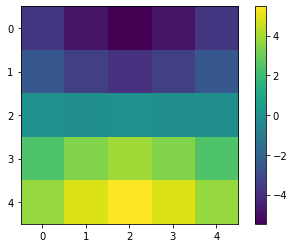

In [50]:
def generate_kernel(kernel_size, polar_filter):
  def polar_coord_distance(r1, theta1, r2, theta2):
    return (r1**2 + r2**2 - 2*r1*r2*np.cos(theta1-theta2))**0.5

  complex_kernel = [np.zeros((kernel_size, kernel_size)) for i in range(2)]

  angle_iter = 2*np.pi / polar_filter[0].shape[0] 
  radius_iter = 1 / polar_filter[0].shape[1]

  for row in range(kernel_size):
    for column in range(kernel_size):

      pixel_x = (column - int(kernel_size/2))/2
      pixel_y = (-1*row + int(kernel_size/2))/2

      pixel_radius = (pixel_x**2 + pixel_y**2)**0.5  
      pixel_angle = np.angle(complex(pixel_x, pixel_y))
        
      pixel_values = [0,0]

      for i,filter_part in enumerate(polar_filter):
        for angle,radii in enumerate(filter_part):
          polar_angle = angle*angle_iter
  
          for radius_index, polar_value in enumerate(radii):
            polar_radius = (radius_index + 1) * radius_iter
  
            distance = polar_coord_distance(pixel_radius, pixel_angle, polar_radius, polar_angle) 
            g_term = np.e**(-distance / (2*(1.5**2)))
  
            pixel_values[i] += g_term * polar_value

        complex_kernel[i][row,column] = pixel_values[i]

  return tuple(complex_kernel)

discretized_kernel = generate_kernel(5, polar_filter)

visualize_polar_filter(lambda r: np.e**(r**2), -1, 0)

for k in discretized_kernel:
  fig, ax = plt.subplots()
  shw = ax.imshow(k)
  bar = plt.colorbar(shw)
  plt.show()
  

Above, we see the real and imaginary values of the continuous and discretized harmonic edge-filters.

We can now use our discretized filters for the familiar convolution task we encountered above. However, our convolution calculations will be a little different, seeing as we are working with a complex-valued kernel.

**QUESTION: How would much high rotational order (e.g. > 4) affect the discretization of the filters?**

With a higher rotational order eventually there will be whole rotations with a single pixel and thus only the average magnitude value will be captured within the pixel.  This can be seen above with a rotational order of 100.

The complex-cross correlation we will use is provided in the paper:

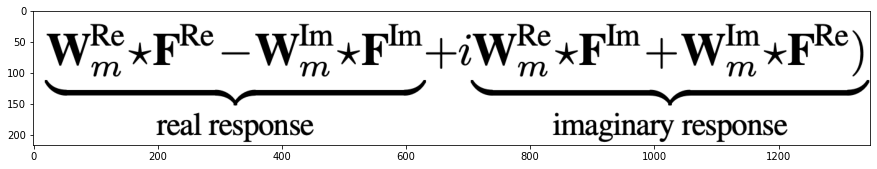

In [51]:
complex_cc = io.imread("complex_cc.png")
plt.figure(figsize = (15,15))
plt.imshow(complex_cc)

Conveniently, the grayscale image has no imaginary component, so any terms involving the imaginary part of the image (F**Im) may be zerod out, leaving us with two convolutions to arrive at a real and imaginary response. 

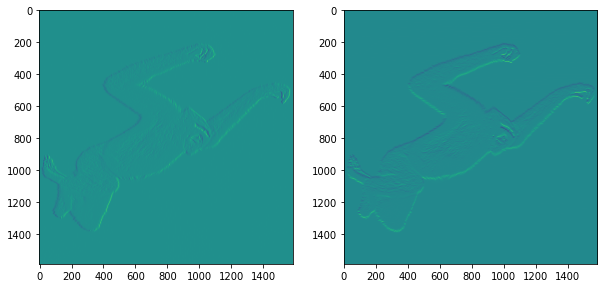

In [52]:
def generate_complex_feature_map(image, kernel):
  feature_map = [np.zeros((image.shape[0] - kernel[0].shape[0] + 1,
                           image.shape[1] - kernel[0].shape[1] + 1)) for x in range(2)]

  for r in range(image.shape[0] - kernel[0].shape[0]):
    for c in range(image.shape[1] - kernel[0].shape[1]):
      img_patch = image[r:r+kernel[0].shape[0], c:c+kernel[0].shape[1]]

      for i in range(2):
        feature_map[i][r,c] = np.dot(img_patch.flatten(), kernel[i].flatten())
  
  return tuple(feature_map)

complex_map = generate_complex_feature_map(img_gray, discretized_kernel)

f,ax = plt.subplots(1,2, figsize=(10,10))

for i,image in enumerate(complex_map):
  ax[i].imshow(image)

plt.show()

Above is the real and imaginary responses to the complex convolution. At this point, you may be surprised that the edge detection doesn't appear to have improved much. 

Let's take a look at a feature map composed of the magnitude of the complex response, not the real and imaginary responses in isolation.

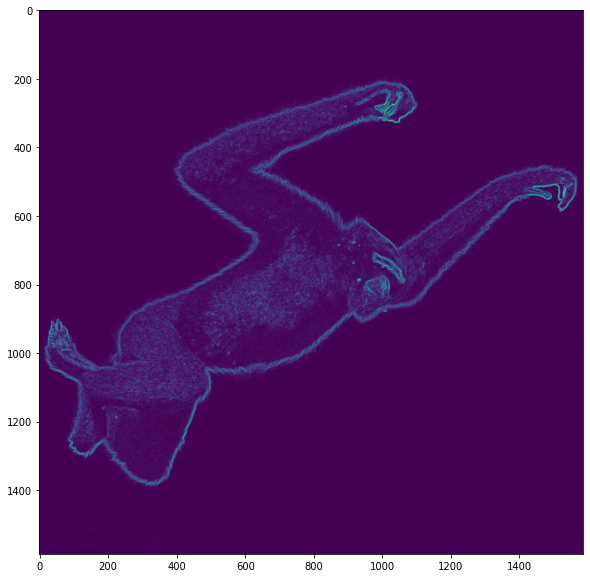

In [53]:
def generate_magnitude_map(complex_map):
  mag_map = np.zeros(complex_map[0].shape)
  
  for i in range(complex_map[0].shape[0]):
    for j in range(complex_map[0].shape[1]):
      magnitude = (complex_map[0][i,j]**2 + complex_map[1][i,j]**2)**0.5 
      # magnitude = np.angle(complex(real_map[i,j], complex_map[i,j])) 
      mag_map[i,j] = magnitude
  
  return mag_map

mag_map = generate_magnitude_map(complex_map)
plt.figure(figsize = (10,10))
plt.imshow(mag_map)

That's more like it.

To verify that harmonic filter really do improve angle-sensitivity to edge detection, let's perform the same operation on all rotated versions of the original image.

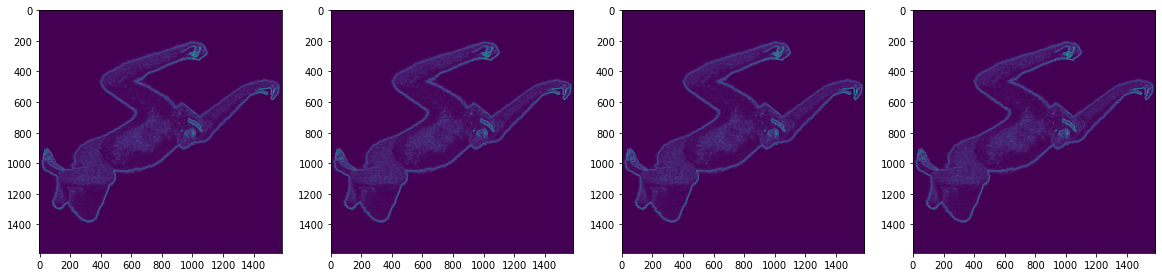

In [48]:
complex_maps = [generate_complex_feature_map(image, discretized_kernel) for image in rotated_imgs]
mag_maps = [generate_magnitude_map(c_map) for c_map in complex_maps]

aligned_mag_maps = [mag_maps[0]]

for i in range(1, len(mag_maps)):
  aligned_mag_maps.append(np.rot90(mag_maps[i],4-i))

f,ax = plt.subplots(1,4, figsize=(20,20))

for i,image in enumerate(aligned_mag_maps):
  ax[i].imshow(image)

plt.show()

**Questions: What do you observe about the edge filters response to rotation? How does this differ from the original filters?**

In response to rotation there is very little difference among edge filters, whereas there was a significant difference in the original filters.

**Why are these harmonic filters robust to changes in input angle?**

The filters have a corresponding change which occurs when the input image is rotated.  Therefore rotating the image then applying the filter is equivalent to applying the filter and then the corresponding change.  This is known as equivarience.